<a href="https://colab.research.google.com/github/aditya9049/image-colorization/blob/main/CA_2_CVPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os

DATA_DIR = '/content/drive/MyDrive/data'



In [3]:
# Install OpenCV
!pip install matplotlib-venn
!pip install tensorflow

# Now import the libraries
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam


In [4]:
# Constants
IMAGE_SIZE = 128
DATA_DIR = '/content/drive/MyDrive/data'

In [5]:
def load_images(folder, color_mode='rgb'):
    images = []
    for filename in sorted(os.listdir(folder)):
        path = os.path.join(folder, filename)
        img = cv2.imread(path)
        if img is None:
            continue
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        if color_mode == 'gray':
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = np.expand_dims(img, axis=-1)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype('float32') / 255.0
        images.append(img)
    return np.array(images)

In [6]:
# Load images from Drive
x_train = load_images(os.path.join(DATA_DIR, 'train_black'), color_mode='gray')
y_train = load_images(os.path.join(DATA_DIR, 'train_color'), color_mode='rgb')
x_test = load_images(os.path.join(DATA_DIR, 'test_black'), color_mode='gray')
y_test = load_images(os.path.join(DATA_DIR, 'test_color'), color_mode='rgb')

print("Train Gray:", x_train.shape)
print("Train Color:", y_train.shape)

Train Gray: (5000, 128, 128, 1)
Train Color: (5000, 128, 128, 3)


In [7]:
# Autoencoder Architecture
# Autoencoder Architecture
from tensorflow.keras.layers import  BatchNormalization, Dropout # Import BatchNormalization and Dropout

input_img = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

# Encoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x) # Use Dropout here
x = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
input_img = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

# Encoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [8]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(), loss='mse')
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 299,139 (1.14 MB)

 Trainable params: 298,371 (1.14 MB)

 Non-trainable params: 768 (3.00 KB)

In [9]:
# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train model
history=autoencoder.fit(x_train, y_train,
                epochs=20,
                batch_size=32,
                shuffle=True,
                validation_split=0.1,
                callbacks=[early_stop, reduce_lr])

Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 31s 141ms/step - loss: 0.0248 - val_loss: 0.0516 - learning_rate: 0.0010
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - loss: 0.0133 - val_loss: 0.0394 - learning_rate: 0.0010
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 0.0126 - val_loss: 0.0331 - learning_rate: 0.0010
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 0.0121 - val_loss: 0.0212 - learning_rate: 0.0010
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 0.0114 - val_loss: 0.0163 - learning_rate: 0.0010
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0113 - val_loss: 0.0143 - learning_rate: 0.0010
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0108 - val_loss: 0.0116 - learning_rate: 0.0010
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 0.0110 - val_loss: 0.0232 - learning_rate: 0.0010
Epoch 9/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 0.0105 - val_loss: 0.0130 - learning_rate: 

In [10]:
# Prediction
decoded_imgs = autoencoder.predict(x_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step


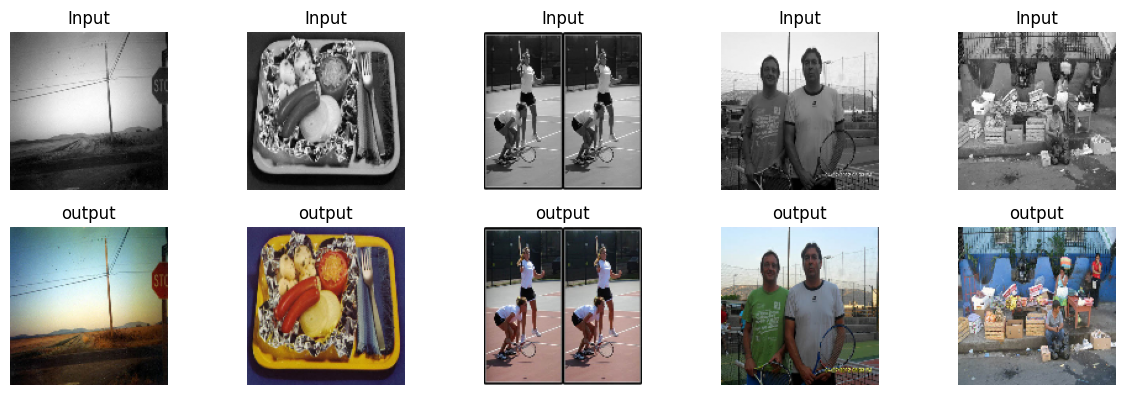

In [13]:
# Visualize results
n = 5
plt.figure(figsize=(12, 6))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title("Input")
    plt.axis('off')

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(y_test[i])
    plt.title("output")
    plt.axis('off')


plt.tight_layout()
plt.show()

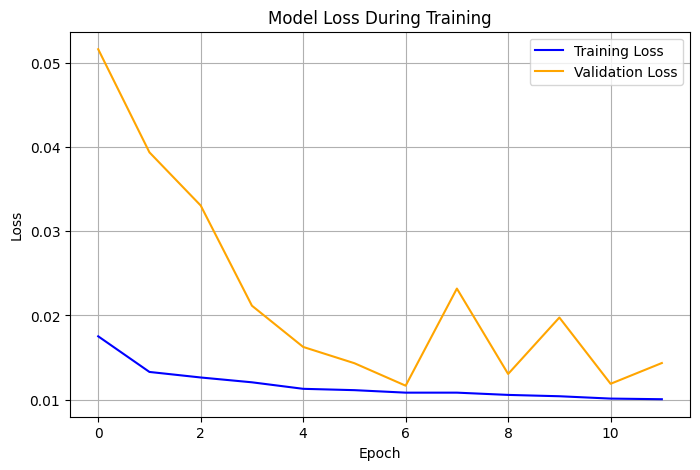

In [14]:
# Plot training & validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [24]:
# U-Net Architecture
def unet(input_size=(128, 128, 1)):
    inputs = Input(input_size)

In [28]:
# U-Net Architecture
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate

def unet(input_size=(128, 128, 1)):
    inputs = Input(input_size)
 # Encoder
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D()(c3)

    c4 = Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(512, 3, activation='relu', padding='same')(c4)

    # Decoder
    u5 = UpSampling2D()(c4)
    u5 = Concatenate()([u5, c3])
    c5 = Conv2D(256, 3, activation='relu', padding='same')(u5)
    c5 = Conv2D(256, 3, activation='relu', padding='same')(c5)

    u6 = UpSampling2D()(c5)
    u6 = Concatenate()([u6, c2])
    c6 = Conv2D(128, 3, activation='relu', padding='same')(u6)
    c6 = Conv2D(128, 3, activation='relu', padding='same')(c6)

    u7 = UpSampling2D()(c6)
    u7 = Concatenate()([u7, c1])
    c7 = Conv2D(64, 3, activation='relu', padding='same')(u7)
    c7 = Conv2D(64, 3, activation='relu', padding='same')(c7)

    outputs = Conv2D(3, 1, activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    return model

In [29]:
# Build and compile U-Net model
unet_model = unet()
unet_model.compile(optimizer=Adam(), loss='mse')
unet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 128, 128,  │        640 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_13[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_15[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_6[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_17[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_7[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_19[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 32, 32,    │          0 │ conv2d_20[0][0]   │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling2d_3[… │
│ (Concatenate)       │ 768)              │            │ conv2d_18[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 32, 32,    │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_21[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 64, 64,    │          0 │ conv2d_22[0][0] 

 Total params: 7,781,891 (29.69 MB)

 Trainable params: 7,781,891 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Train
history=unet_model.fit(x_train, y_train,
               epochs=10,
               batch_size=16,
               validation_split=0.1,
               shuffle=True)

Epoch 1/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 49s 173ms/step - loss: 0.0064 - val_loss: 0.0077
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 81s 170ms/step - loss: 0.0062 - val_loss: 0.0073
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 83s 172ms/step - loss: 0.0063 - val_loss: 0.0083
Epoch 4/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 82s 172ms/step - loss: 0.0064 - val_loss: 0.0075
Epoch 5/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 81s 169ms/step - loss: 0.0061 - val_loss: 0.0074
Epoch 6/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 82s 170ms/step - loss: 0.0061 - val_loss: 0.0076
Epoch 7/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 48s 172ms/step - loss: 0.0061 - val_loss: 0.0075
Epoch 8/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 82s 170ms/step - loss: 0.0059 - val_loss: 0.0074
Epoch 9/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 48s 171ms/step - loss: 0.0059 - val_loss: 0.0079
Epoch 10/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 48s 171ms/step - loss: 0.0059 - val_loss: 0.0074


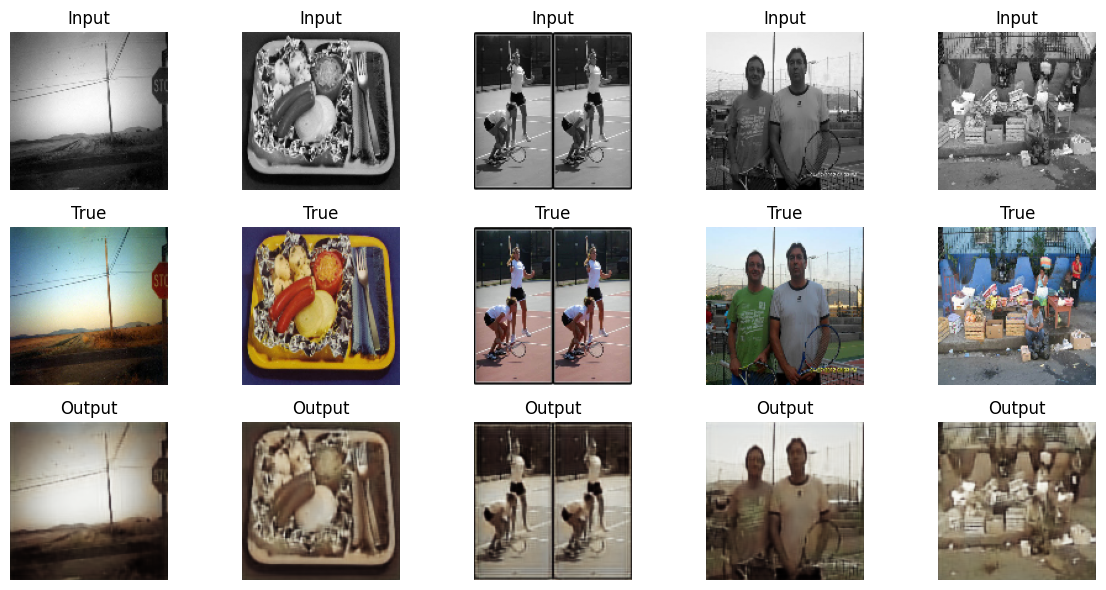

In [34]:
# Visualization
n = 5
plt.figure(figsize=(12, 6))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title("Input")
    plt.axis('off')

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(y_test[i])
    plt.title("True")
    plt.axis('off')

    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i])
    plt.title("Output")
    plt.axis('off')

plt.tight_layout()
plt.show()

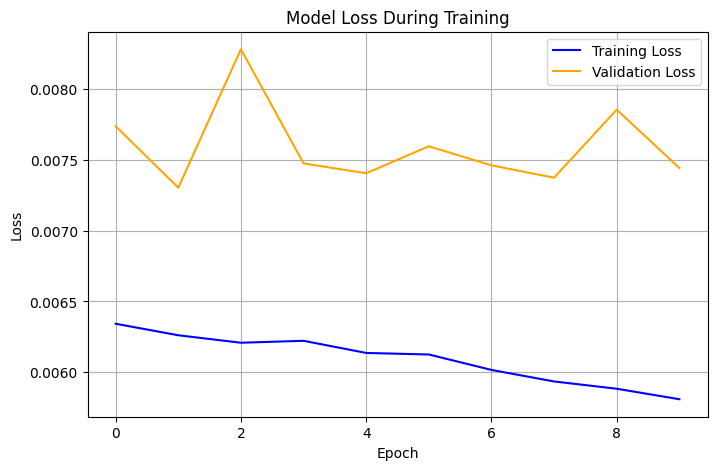

In [35]:
# Plot training & validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()